In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Research 1.0/model/sentiNOB/'
model_name = "Kowsher/bangla-bert"

**IMPORTING LIBRARIES**

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00


In [4]:
#Importing stock ml libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,json,nltk
import transformers
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from pylab import rcParams
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap
from transformers import DataCollatorWithPadding
from tqdm import tqdm
import tensorflow as tf


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**DATA READING & CLEANING**

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Research 1.0/Data-set/SentiNOB/Train.csv',encoding='UTF-8')
data_test = pd.read_csv('/content/drive/MyDrive/Research 1.0/Data-set/SentiNOB/Test.csv',encoding='UTF-8')
data_val = pd.read_csv('/content/drive/MyDrive/Research 1.0/Data-set/SentiNOB/Val.csv',encoding='UTF-8')

In [7]:
# Data cleaning function
def process_comments(Comment):
    Comment = re.sub('[^\u0980-\u09FF]',' ',str(Comment)) #removing unnecessary punctuation
    return Comment

def remove_bnDigit(Comment):
    Comment = re.sub('[০-৯]',' ',str(Comment)) #removing unnecessary digit
    return Comment

# Apply the function into the dataframe
data['Data'] = data['Data'].apply(process_comments)
data_test['Data'] = data_test['Data'].apply(process_comments)
data_val['Data'] = data_val['Data'].apply(process_comments)

# Apply the function into the dataframe
data['Data'] = data['Data'].apply(remove_bnDigit)
data_test['Data'] = data_test['Data'].apply(remove_bnDigit)
data_val['Data'] = data_val['Data'].apply(remove_bnDigit)

# renaming Data to review
data.rename(columns={"Data": "review"}, inplace=True)
data_test.rename(columns={"Data": "review"}, inplace=True)
data_val.rename(columns={"Data": "review"}, inplace=True)

data.drop(data.index[(data["Label"] == "conflict")],axis=0,inplace=True)
len(data)

# removing duplicate review
data.drop_duplicates(subset="review", keep="first", inplace=True)
len(data)

11984

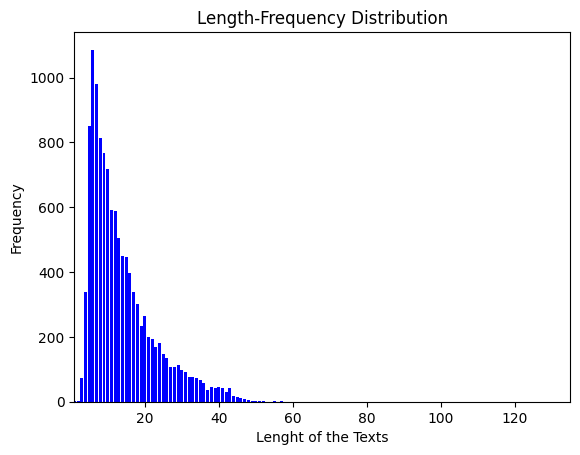

Maximum Length of a review: 57
Minimum Length of a review: 0
Average Length of a reviews: 14.0


In [8]:
# Calculate the length of each Review
data['ReviewLength'] = data.review.apply(lambda x:len(x.split()))
frequency = dict()
for i in data.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a review: {max(data.ReviewLength)}")
print(f"Minimum Length of a review: {min(data.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(data.ReviewLength),0)}")

In [9]:
# Length of each Reveiws
data['length'] = data['review'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
data = data.loc[data.length>3]
data = data.loc[data.length<51]
data = data.reset_index(drop = True)

In [10]:
data.drop("ReviewLength",axis=1,inplace=True)
data.drop("length",axis=1,inplace=True)

In [11]:
data_val['Label'].unique()

array([1, 2, 0])

In [12]:
df_train  = data
df_val = data_val
df_test = data_test

In [13]:
# df_train['Label'] = df_train['Label'].replace(['0','1','2'],[0,1,2])
# df_val['Label'] = df_val['Label'].replace(['0','1','2'],[0,1,2])
# df_test['Label'] = df_test['Label'].replace(['0','1','2'],[0,1,2])

In [14]:
type(df_train['Label'])

pandas.core.series.Series

**IMPLIMENTATION START HERE**

In [15]:
tokenizer = BertTokenizer.from_pretrained(model_name)

Tokenization and encoding on a Sample Text

In [16]:
sample_txt = 'আমি একটা বোকা ছেলে'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: আমি একটা বোকা ছেলে
   Tokens: ['আমি', 'একটা', 'বে', '##াকা', 'ছেলে']
Token IDs: [2169, 2157, 6072, 25201, 2847]


In [17]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    pad_to_max_length = True,
    return_attention_mask=True,
    return_tensors='pt')  # Return PyTorch tensors)

print(f'Encoding keys: {encoding.keys()}')

print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])

print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

Encoding keys: dict_keys(['input_ids', 'attention_mask'])
32
tensor([  101,  2169,  2157,  6072, 25201,  2847,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
32
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
['[CLS]', 'আমি', 'একটা', 'বে', '##াকা', 'ছেলে', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [18]:
tokens = tokenizer.encode(sample_txt,truncation=True, max_length=50)
print(tokens)

[101, 2169, 2157, 6072, 25201, 2847, 102]


**DATA LOADER**

In [19]:
df_train.head()

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0


In [20]:
print(df_train.shape, df_val.shape, df_test.shape)

(11898, 2) (1567, 2) (1586, 2)


In [21]:
MAX_LEN = 70
BATCH_SIZE = 16

pre_trained_model_ckpt = model_name

class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            padding = 'max_length',
            pad_to_max_length = True,
            return_tensors = 'pt',)

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        if self.include_raw_text:
            output['review_text'] = review

        return output

collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = 'longest' )

def create_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_text = False ):
    ds = ReviewDataset(
        reviews = df.review.to_list(),
        targets = df.Label.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text
    )
    return DataLoader(ds, batch_size=batch_size, collate_fn=collator )

In [22]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer)
test_data_loader = create_data_loader(df_test, tokenizer)

In [23]:
for d in val_data_loader:
    print(d.keys())

dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'att

In [24]:
data = next(iter(train_data_loader))

In [25]:
print(data.keys())
print(data['input_ids'].shape) # torch.Size([16, 512])
print(data['attention_mask'].shape) # torch.Size([16, 512])
print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 70])
torch.Size([16, 70])
torch.Size([16])


**CLASSIFICATION MODEL**

In [26]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_ckpt,return_dict=False)
        # self.drop = nn.Dropout(p = 0.3)
        # self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

        self.lstm = nn.LSTM(768, 64, batch_first=True,bidirectional=True)
        self.linear = nn.Linear(64*2, n_classes)




    def forward(self, input_ids, attention_mask):

        sequence_output, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )

        # output = self.drop(pooled_output)


        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
        hidden = torch.cat((lstm_output[:,-1, :64],lstm_output[:,0, 64:]),dim=-1)
        linear_output = self.linear(hidden.view(-1,64*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

        return linear_output

        # return self.out(output)

In [27]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at Kowsher/bangla-bert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
EPOCHS = 25

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps)

# For multi-class classification you would usually just use nn.CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss().to(device)

**TRAIN FUNCTION**

In [29]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

    model=model.train()
    losses = []
    correct_predictions = 0

    for _,data in tqdm(enumerate(data_loader, 0), unit="16", total=len(data_loader)):
    # for d in data_loader:

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets).cpu()

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions/n_examples, np.mean(losses)




**EVALUATION FUNCTION**

In [30]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for _,data in tqdm(enumerate(data_loader, 0), unit="16", total=len(data_loader)):
        # for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets.detach())
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())
    return correct_predictions/n_examples, np.mean(losses)

**PREDICTION FUNCTION**

In [31]:
# Model Evaluation on test_data_loader
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for _,data in tqdm(enumerate(data_loader, 0), unit="16", total=len(data_loader)):
        # for d in data_loader:
            # texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            # review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

**TRAINING LOOP**

In [32]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/ 25
---------------


100%|██████████| 744/744 [02:49<00:00,  4.3916/s]


Train loss 0.05157056810573414 accuracy 0.9335182309150696


100%|██████████| 98/98 [00:06<00:00, 14.4416/s]


Val loss 0.0025421788450330496 accuracy 0.9380982518196106
Epoch 2/ 25
---------------


100%|██████████| 744/744 [02:48<00:00,  4.4216/s]


Train loss 0.0019840161314219115 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:08<00:00, 11.4116/s]


Val loss 0.0013476447202265263 accuracy 0.9380982518196106
Epoch 3/ 25
---------------


100%|██████████| 744/744 [02:48<00:00,  4.4116/s]


Train loss 0.0011113027099116895 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:07<00:00, 13.9916/s]


Val loss 0.000858686922583729 accuracy 0.9380982518196106
Epoch 4/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.0007533177698058606 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.2116/s]


Val loss 0.0006224408280104399 accuracy 0.9380982518196106
Epoch 5/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.000548302015319081 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.6016/s]


Val loss 0.0004592096956912428 accuracy 0.9380982518196106
Epoch 6/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.0004084751979912311 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.5316/s]


Val loss 0.0003424182359594852 accuracy 0.9380982518196106
Epoch 7/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.0003019273525585235 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.0816/s]


Val loss 0.0002561936271376908 accuracy 0.9380982518196106
Epoch 8/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.00022659235800083185 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.6516/s]


Val loss 0.0001936395710799843 accuracy 0.9380982518196106
Epoch 9/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.00017143241107518288 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.1316/s]


Val loss 0.000147140453918837 accuracy 0.9380982518196106
Epoch 10/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 0.00013045430081038702 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7116/s]


Val loss 0.00011251096293563023 accuracy 0.9380982518196106
Epoch 11/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 9.98751324083079e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7216/s]


Val loss 8.643866021884605e-05 accuracy 0.9380982518196106
Epoch 12/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 7.697449714752472e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.1116/s]


Val loss 6.688993016723543e-05 accuracy 0.9380982518196106
Epoch 13/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 5.967156969364301e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7616/s]


Val loss 5.207712820265442e-05 accuracy 0.9380982518196106
Epoch 14/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 4.663354735306692e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.3816/s]


Val loss 4.0927632653620094e-05 accuracy 0.9380982518196106
Epoch 15/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 3.6729756947772664e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.1216/s]


Val loss 3.239258148823865e-05 accuracy 0.9380982518196106
Epoch 16/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4416/s]


Train loss 2.921268968190904e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7216/s]


Val loss 2.5939583792933263e-05 accuracy 0.9380982518196106
Epoch 17/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 2.34862755953282e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7216/s]


Val loss 2.0988547476008534e-05 accuracy 0.9380982518196106
Epoch 18/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 1.9117172862161658e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.0716/s]


Val loss 1.721366606943775e-05 accuracy 0.9380982518196106
Epoch 19/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4416/s]


Train loss 1.5777099782988894e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7416/s]


Val loss 1.4289111277321354e-05 accuracy 0.9380982518196106
Epoch 20/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 1.3238418663633873e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.2516/s]


Val loss 1.213542782352306e-05 accuracy 0.9380982518196106
Epoch 21/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 1.1326534170484104e-05 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.6116/s]


Val loss 1.0538041351537686e-05 accuracy 0.9380982518196106
Epoch 22/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 9.915394040641937e-06 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.4216/s]


Val loss 9.274436706618872e-06 accuracy 0.9380982518196106
Epoch 23/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 8.905255042684016e-06 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.3616/s]


Val loss 8.503557182848454e-06 accuracy 0.9380982518196106
Epoch 24/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 8.252024087440038e-06 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:06<00:00, 14.7416/s]


Val loss 7.979041583894286e-06 accuracy 0.9380982518196106
Epoch 25/ 25
---------------


100%|██████████| 744/744 [02:47<00:00,  4.4316/s]


Train loss 7.92923236208627e-06 accuracy 0.9379727840423584


100%|██████████| 98/98 [00:07<00:00, 13.8116/s]

Val loss 7.835991709725931e-06 accuracy 0.9380982518196106


<function matplotlib.pyplot.show(close=None, block=None)>

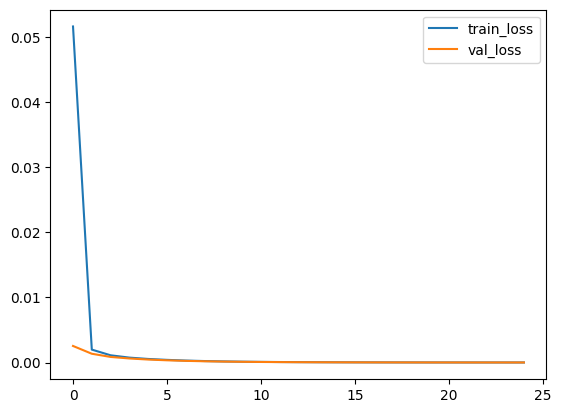

In [33]:
from matplotlib import pyplot as plt
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

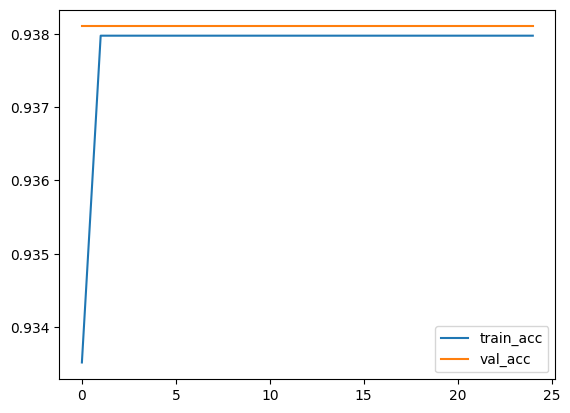

In [34]:
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'],label='val_acc')
plt.legend()
plt.show

In [35]:
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred))

100%|██████████| 100/100 [00:06<00:00, 16.5216/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       700
           2       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [36]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[300,   0,   0],
       [  0, 700,   0],
       [  0,   0, 500]])

In [37]:
class_names = ['Neutral','Positive','Negative']

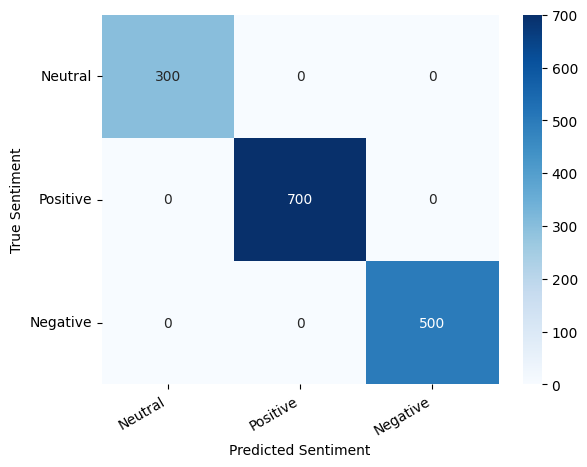

In [38]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [39]:


review_text = "বর্তমানে আমাদের দেশের অবস্থা ভালো না হওয়ায় বেশিরভাগ শিক্ষার্থীই দেশ ছেড়ে চলে যাচ্ছে"

encoded_review = tokenizer.encode_plus(review_text,
                                       max_length=MAX_LEN,
                                       add_special_tokens=True,
                                       return_token_type_ids=False,
                                       padding='max_length',
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       truncation=True,
                                       return_tensors='pt')

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: বর্তমানে আমাদের দেশের অবস্থা ভালো না হওয়ায় বেশিরভাগ শিক্ষার্থীই দেশ ছেড়ে চলে যাচ্ছে
Sentiment  : Negative
